# 2nd Level Model Structure: Reactive Stage

In [1]:
import sys
import os
import dill
import pickle
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../..'))
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from pyomo import environ as pe
from global_sets.component import m
from utility.display_utility import trans_product_mole, trans_product_mass
from utility.model_utility import add_dual, update_dual, check_DOF, augmented_objective, add_solver,\
                                    select_MPCC, which_MPCC, disable_restoration

# stage construction rules
from physics.kinetics.kinetics_reactive import kinetic_block_rule
from physics.energy.energy_reactive import energy_block_rule
from physics.VLE.VLE_reactive_MPCC_P import VLE_block_rule
from physics.MPCC.MPCC_P import P_NCP_block_rule, P_Reg_block_rule, P_pf_block_rule

In [3]:
model = pe.ConcreteModel()

# Global Sets (Inlet / Outlet)

In [4]:
model.inlet = pe.Set(initialize=['in','R'])
model.outlet = pe.Set(initialize=['out','P'])
model.stream = model.inlet | model.outlet

# Global Variables

In [5]:
# Tray Inlet/Outlet Variable
model.x_ = pe.Var(model.inlet,m.COMP_TOTAL,within=pe.NonNegativeReals)
model.y_ = pe.Var(model.inlet,m.COMP_TOTAL,within=pe.NonNegativeReals)
model.x = pe.Var(m.COMP_TOTAL,within=pe.NonNegativeReals)
model.y = pe.Var(m.COMP_TOTAL,within=pe.NonNegativeReals)
model.z = pe.Var(m.COMP_FEED,within=pe.NonNegativeReals)

model.L = pe.Var(model.stream,within=pe.NonNegativeReals)
model.V = pe.Var(model.stream,within=pe.NonNegativeReals)
model.F = pe.Var(within=pe.NonNegativeReals)

model.H_L_ = pe.Var(model.inlet,within=pe.Reals)
model.H_V_ = pe.Var(model.inlet,within=pe.Reals)
model.H_L = pe.Var(within=pe.Reals)
model.H_V = pe.Var(within=pe.Reals)
model.H_F = pe.Var(within=pe.Reals)

# State Variable
model.T = pe.Var(within=pe.NonNegativeReals,bounds=(200+273.15,300+273.15)) # K
model.T_F = pe.Var(within=pe.NonNegativeReals) # K
model.P = pe.Var(within=pe.NonNegativeReals,bounds=(10,30)) # Bar

model.f_V = pe.Var(m.COMP_TOTAL,within=pe.NonNegativeReals,initialize=1e-20)
model.f_L = pe.Var(m.COMP_TOTAL,within=pe.NonNegativeReals,initialize=1e-20)

model.cat = pe.Var(within=pe.NonNegativeReals,initialize=30000) # kg
model.Q_main = pe.Var(within=pe.Reals) # MW
model.r_total_comp = pe.Var(m.COMP_TOTAL,within=pe.Reals) # kmol/s

# Construct Individual Blocks

In [6]:
if model.find_component('kinetics_block'):
    print('haha')

In [7]:
model.kinetics_block = pe.Block(rule=kinetic_block_rule)

> Importing Kinetics Blocks......
> Adding the following local variable:
--------------------------------------------------
| kinetics_block.k_FT
| kinetics_block.r_FT_total
| kinetics_block.g0_FT
| kinetics_block.alpha
| kinetics_block.r_FT_cnum
| kinetics_block.r_FT_comp
| kinetics_block.k_WGS
| kinetics_block.Ke_WGS
| kinetics_block.r_WGS
| kinetics_block.r_WGS_comp
--------------------------------------------------



In [8]:
model.energy_block = pe.Block(rule=energy_block_rule)

> Importing Energy Blocks......
> Adding the following local variable:
--------------------------------------------------
| energy_block.dH_F
| energy_block.dH_V
| energy_block.dH_L
| energy_block.dH_vap
--------------------------------------------------



In [9]:
model.VLE_block = pe.Block(rule=VLE_block_rule)

> Importing VLE Blocks......
> Adding the following local variable:
--------------------------------------------------
| VLE_block.P_VLE
| VLE_block.n_ave
| VLE_block.n_ave_cal
| VLE_block.Hen
| VLE_block.Hen0
| VLE_block.gamma
| VLE_block.P_sat
| VLE_block.P_sat_Y
| VLE_block.P_sat_dY_inf
| VLE_block.P_sat_dY0
| VLE_block.Hen_ref
| VLE_block.Hen0_ref
| VLE_block.gamma_ref
| VLE_block.V_L
| VLE_block.V_L_dY_inf
| VLE_block.V_L_dY0
| VLE_block.poynting
--------------------------------------------------



# Standard MESH Equations

## Mass Balance

\begin{equation}
Fz_{i}+\sum_{s\in{inlet}}L_{s}x'_{i,s}+\sum_{s\in{inlet}}V_{s}y'_{i,s}-\sum_{s\in{outlet}}L_{s}x_{i,s}+\sum_{s\in{ouelet}}V_{s}y_{i,s}+R_{i} = 0 \\
i = 1,...NC
\end{equation}

In [10]:
def mass_balance_main_rule(model,i):
    if i in m.COMP_FEED:
        return model.F*model.z[i] + sum(model.L[s]*model.x_[s,i] + model.V[s]*model.y_[s,i] for s in model.inlet)\
        + model.r_total_comp[i] - sum(model.L[s]*model.x[i] + model.V[s]*model.y[i] for s in model.outlet) == 0
    else:
        return sum(model.L[s]*model.x_[s,i] + model.V[s]*model.y_[s,i] for s in model.inlet)\
        + model.r_total_comp[i] - sum(model.L[s]*model.x[i] + model.V[s]*model.y[i] for s in model.outlet) == 0
model.mass_balance_main_con = pe.Constraint(m.COMP_TOTAL,rule=mass_balance_main_rule)

## Equilibrium

\begin{align}
&f_{i,V} = f_{i,L} \\
&i = 1,...NC
\end{align}

In [11]:
def VL_equil_rule(model,i):
    return model.f_V[i] == model.f_L[i]
model.VL_equil_con = pe.Constraint(m.COMP_TOTAL,rule=VL_equil_rule)

## MPCC: Add all three

In [12]:
model.MPCC_P_pf = pe.Block(rule = P_pf_block_rule)
model.MPCC_P_NCP = pe.Block(rule = P_NCP_block_rule)
model.MPCC_P_Reg = pe.Block(rule = P_Reg_block_rule)

> Importing MPCC_P_pf Blocks......
> Adding the following local variable:
--------------------------------------------------
| MPCC_P_pf.s_L
| MPCC_P_pf.s_V
| MPCC_P_pf.pf
| MPCC_P_pf.epi
| MPCC_P_pf.rho
--------------------------------------------------
> Spliting pressure used in VLE
Deleted original P_equal constraint

> Deleted kinetics rates constraints
> Added f_V_MPCC, updated rates constraints

> Importing MPCC_P_NCP Blocks......
> Adding the following local variable:
--------------------------------------------------
| MPCC_P_NCP.s_L
| MPCC_P_NCP.s_V
| MPCC_P_NCP.epi
--------------------------------------------------
> Adding complementarity constraint, spliting pressure used in VLE
> No constraint to delete

> Already replaced f_V_MPCC

> Importing MPCC_P_Reg Blocks......
> Adding the following local variable:
--------------------------------------------------
| MPCC_P_Reg.s_L
| MPCC_P_Reg.s_V
| MPCC_P_Reg.epi
--------------------------------------------------
> Adding comple

In [13]:
select_MPCC(model,'pf')

> Selected MPCC: MPCC_P_pf
s_L:  0
s_V:  0



## Summation

\begin{equation}
\sum_ix_{i} = \sum_iy_{i} \\
F + L_{in} + V_{in} + R = L_{out} + V_{out}
\end{equation}

In [14]:
def summation_x_y_rule(model):
    return sum(model.x[i] for i in m.COMP_TOTAL) == sum(model.y[i] for i in m.COMP_TOTAL)
model.summation_x_y_con = pe.Constraint(rule=summation_x_y_rule)

def summation_total_mass_rule(model):
    return model.F + sum(model.L[s] + model.V[s] for s in model.inlet) + sum(model.r_total_comp[i] for i in m.COMP_TOTAL)\
            - sum(model.L[s] + model.V[s] for s in model.outlet) == 0
model.summation_total_mass_con = pe.Constraint(rule=summation_total_mass_rule)

## Energy Balance

\begin{equation}
F H_f+\sum_{s\in{inlet}}L_{s}H_{l,s}+\sum_{s\in{inlet}}V_{s}H_{v,s}-\sum_{s\in{outlet}}L_{s}H_{l,s}-\sum_{s\in{outlet}}V_{s}H_{v,s}+Q = 0
\end{equation}

In [15]:
def heat_balance_main_rule(model):
    return model.F*model.H_F + sum(model.L[s]*model.H_L_[s] + model.V[s]*model.H_V_[s] for s in model.inlet) \
            + model.Q_main - sum(model.L[s]*model.H_L + model.V[s]*model.H_V for s in model.outlet) == 0
model.heat_balance_main_con = pe.Constraint(rule=heat_balance_main_rule)

# Testing

In [16]:
add_dual(pe,model)

Created the follow pyomo suffixes:
ipopt_zL_out, ipopt_zU_out, ipopt_zL_in, ipopt_zU_in, dual


## Fixing In/Product Redundent Flow

In [17]:
model.x_.fix(0)
model.y_.fix(0)
model.L['in'].fix(0)
model.L['R'].fix(0)
model.L['P'].fix(0)

model.V['in'].fix(0)
model.V['R'].fix(0)
model.V['P'].fix(0)
model.H_L_.fix(0)
model.H_V_.fix(0)

## Fixing Model Parameters

In [18]:
model.cat.fix(30000)
model.P.fix(20)
model.T_F.fix(200+273.15)
model.F.fix(10)
model.z['CO'].fix(1/(1+2)-0/2)
model.z['H2'].fix(2/(1+2)-0/2)
model.z['C30H62'].fix(0)
model.VLE_block.n_ave.fix(20)

## Fix T or to fix Q? we have found that Maximize against an upper bound is most reliable

In [19]:
model.T.setub(300+273.15)

In [20]:
model.obj = augmented_objective(pe, model, expr = model.T, sense=pe.maximize)

------------------------------------------------------------------------------------------------------------
> Obj = maximize
> T - MPCC_P_pf.pf
------------------------------------------------------------------------------------------------------------


In [21]:
opt = add_solver(pe, max_iter = 5000, warm_start = False, output = False)
disable_restoration(mode = 'enable')

In [22]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.10: print_user_options=yes
tol=1e-08
option_file_name=./ipopt.opt
max_iter=5000

Using option file "./ipopt.opt".


List of user-set options:

                                    Name   Value                used
                           compl_inf_tol = 1                     yes
                         constr_viol_tol = 1                     yes
                            dual_inf_tol = 1000                  yes
                           linear_solver = ma97                  yes
                              ma86_small = 1e-30                  no
                                  ma86_u = 0.0001                 no
                              ma97_order = best                  yes
                              ma97_small = 1e-30                 yes
                            ma97_switch1 = at_start              yes
                            ma97_switch2 = od_hd_reuse           yes
                                  ma97_u = 1e-06                 yes
                  

  73r-5.0009610e+02 5.16e+01 9.99e+02   1.0 0.00e+00    -  0.00e+00 3.54e-07R  5
  74r-5.0009512e+02 5.03e+01 3.11e+03   1.0 9.53e+03    -  1.64e-03 6.81e-05f  1
  75r-5.0006596e+02 2.84e+01 8.01e+03   1.0 3.42e+03    -  4.53e-03 2.03e-03f  1
  76 -5.0006438e+02 2.84e+01 1.39e+00  -1.0 3.51e+03    -  9.60e-05 8.16e-05h  1
  77 -5.0006301e+02 2.84e+01 1.13e+00  -1.0 2.82e+03    -  1.61e-04 2.03e-04f  1
  78r-5.0006301e+02 2.84e+01 9.99e+02   0.8 0.00e+00    -  0.00e+00 3.32e-07R  4
  79r-5.0006280e+02 2.83e+01 9.99e+02   0.8 7.34e+02    -  6.28e-04 2.01e-05f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80r-5.0005139e+02 2.02e+01 3.57e+03   0.8 6.83e+02    -  3.56e-03 1.16e-03f  1
  81r-5.0002738e+02 1.41e+01 2.90e+03   0.8 3.91e+02    -  1.78e-03 2.30e-03f  1
  82r-4.9999652e+02 9.77e+00 1.54e+04   0.8 5.00e+02    -  1.37e-02 2.90e-03f  1
  83r-4.9983925e+02 5.60e+00 6.12e+04   0.8 7.30e+02    -  5.49e-02 1.33e-02f  1
  84r-4.9894882e+02 5.24e+00

 168 -5.0892456e+02 3.21e+00 1.14e+09  -1.0 2.13e+03    -  1.00e+00 1.89e-01f  1
 169 -5.1118988e+02 2.58e+00 1.24e+08  -1.0 4.27e+02    -  8.11e-01 7.09e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170 -5.1359225e+02 2.48e+00 6.77e+08  -1.0 3.74e+02    -  9.69e-01 1.00e+00f  1
 171 -5.1464392e+02 4.58e-01 2.28e+07  -1.0 1.64e+02    -  1.00e+00 1.00e+00h  1
 172 -5.1466026e+02 1.06e-04 1.05e+06  -1.0 2.92e+00    -  1.00e+00 1.00e+00h  1
 173 -5.1466107e+02 3.20e-07 2.51e+02  -1.0 1.26e-01    -  1.00e+00 1.00e+00h  1
 174 -5.1740738e+02 4.04e+00 3.31e+08  -3.9 6.16e+02    -  6.88e-01 6.39e-01f  1
 175 -5.1864269e+02 4.97e+00 3.52e+08  -3.9 2.45e+03    -  4.22e-01 7.86e-02f  1
 176 -5.2181441e+02 4.78e+00 1.95e+09  -3.9 6.10e+02    -  8.26e-01 8.20e-01f  1
 177 -5.2209281e+02 4.48e+00 1.76e+09  -3.9 6.43e+02    -  6.30e-03 6.96e-02h  1
 178 -5.2605176e+02 6.64e+00 3.07e+09  -3.9 6.37e+02    -  9.77e-01 1.00e+00f  1
 179 -5.2660459e+02 5.93e+00

Constraint violation....:   8.9692380638352294e-12    1.0913936421275139e-11
Complementarity.........:   9.0909090909091551e-10    9.0909090909091551e-10
Overall NLP error.......:   9.0909090909091551e-10    9.0909090909091551e-10


Number of objective function evaluations             = 475
Number of objective gradient evaluations             = 210
Number of equality constraint evaluations            = 475
Number of inequality constraint evaluations          = 475
Number of equality constraint Jacobian evaluations   = 273
Number of inequality constraint Jacobian evaluations = 273
Number of Lagrangian Hessian evaluations             = 256
Total CPU secs in IPOPT (w/o function evaluations)   =      1.139
Total CPU secs in NLP function evaluations           =      0.076

EXIT: Optimal Solution Found.


In [23]:
print('Component\t\tLiquid: {:.4f}\t\t\tVapor: {:.4f}'.format(model.L['out'].value,model.V['out'].value))
print('-'*108)
for i in model.x:
    print('{:10s}'.format(i),'\t\t{:8.4%}\t\t\t{:8.4%}'.format(model.x[i].value,model.y[i].value))

Component		Liquid: 0.0000			Vapor: 9.9351
------------------------------------------------------------------------------------------------------------
H2         		62.6756%			66.5550%
CO         		36.0167%			32.8969%
CO2        		 0.5778%			 0.2965%
H2O        		 0.1824%			 0.0612%
C2H4       		 0.0732%			 0.0308%
C3H6       		 0.0754%			 0.0177%
C4H8       		 0.0305%			 0.0079%
C5H10      		 0.0219%			 0.0030%
C6H12      		 0.0171%			 0.0014%
C7H14      		 0.0124%			 0.0007%
C8H16      		 0.0087%			 0.0003%
C9H18      		 0.0058%			 0.0001%
C10H20     		 0.0038%			 0.0001%
C11H22     		 0.0016%			 0.0000%
C12H24     		 0.0010%			 0.0000%
C13H26     		 0.0006%			 0.0000%
C14H28     		 0.0004%			 0.0000%
C15H30     		 0.0002%			 0.0000%
C16H32     		 0.0001%			 0.0000%
C17H34     		 0.0001%			 0.0000%
C18H36     		 0.0000%			 0.0000%
C19H38     		 0.0000%			 0.0000%
C20H40     		 0.0000%			 0.0000%
C1H4       		 0.1735%			 0.1014%
C2H6       		 0.0419%			 0.0166%
C3H8       		 0.0177%			

In [24]:
# model.solutions.store_to(results)
# with open('../../saved_solutions/reactive_flash_MPCC_P_200C.pickle','wb') as f:
#     pickle.dump(results,f)

In [25]:
# with open('test_model.pickle','wb') as f:
#     dill.dump(model,f)

# Iterative Solve for Data Analysis

In [26]:
results_anchor = results
update_dual(pe,model)
model.solutions.store_to(results_anchor)

In [27]:
opt = add_solver(pe, max_iter= 500, warm_start = True, output = False)

In [28]:
catrange = [10]
Trange = np.linspace(300+273.15,200+273.15,21)

In [29]:
rf_data_master = {}

for c in catrange:
    model.del_component(model.obj)
    model.obj = augmented_objective(pe, model, expr = model.cat, sense=pe.minimize)

    model.solutions.load_from(results_anchor)
    update_dual(pe,model) 
       
    model.T.fix(300+273.15)
    model.cat.fixed = False
    model.cat.setlb(c)
    
    results_anchor = opt.solve(model,tee=False)
    model.solutions.store_to(results_anchor)
    update_dual(pe,model)
    
    print('\nWorking on Cat = {} kg'.format(model.cat.value))
    print('-'*108)
    
    model.del_component(model.obj)
    model.obj = augmented_objective(pe, model, expr = model.T, sense=pe.maximize)
    model.T.fixed = False
    model.cat.fixed = True

    
    rf_data = {}
    rf_data['x'] = {};rf_data['y'] = {};
    rf_data['T'] = []; rf_data['Q'] = []; rf_data['V'] = []; rf_data['L'] = []; rf_data['P_VLE'] = []; 
    rf_data['s_L'] = [];
    for i in m.COMP_TOTAL:
        rf_data['x'][i] = []
        rf_data['y'][i] = []       

    for t in Trange:
        model.T.setub(t)
        results = opt.solve(model,tee=False)
        update_dual(pe,model)
        model.T.setub(300+273.15)
        
        conv = model.kinetics_block.r_FT_total.value / ( model.F.value * model.z['CO'].value )
        total_conv = 1 - model.V['out'].value*(model.y['CO'].value+model.y['H2'].value) / (model.F.value)
        
        print('Solved\t|T = {:.2f} K | V = {:.4f} kmol/s | L = {:.4f} kmol/s | s_L = {:.4f} | P_VLE = {:.1f} | Conv = {:.1f}'.\
              format(model.T.value,model.V['out'].value,model.L['out'].value,which_MPCC(model).s_L.value,\
                     model.VLE_block.P_VLE.value, 100*conv ))

    
        rf_data['T'].append(model.T.value)
        rf_data['Q'].append(model.Q_main.value)
        rf_data['V'].append(model.V['out'].value)
        rf_data['L'].append(model.L['out'].value)
        rf_data['P_VLE'].append(model.VLE_block.P_VLE.value)
        rf_data['s_L'].append(which_MPCC(model).s_L.value)

        for i in m.COMP_TOTAL:
            rf_data['x'][i].append(model.x[i].value)
            rf_data['y'][i].append(model.y[i].value)
        
    rf_data_master[c] = rf_data

------------------------------------------------------------------------------------------------------------
> Obj = minimize
> cat + MPCC_P_pf.pf
------------------------------------------------------------------------------------------------------------

Working on Cat = 10.0 kg
------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------
> Obj = maximize
> T - MPCC_P_pf.pf
------------------------------------------------------------------------------------------------------------
Solved	|T = 573.15 K | V = 9.9351 kmol/s | L = 0.0000 kmol/s | s_L = 371.4276 | P_VLE = 391.4 | Conv = 1.1
Solved	|T = 568.15 K | V = 9.9440 kmol/s | L = 0.0000 kmol/s | s_L = 376.9860 | P_VLE = 397.0 | Conv = 0.9
Solved	|T = 563.15 K | V = 9.9518 kmol/s | L = 0.0000 kmol/s | s_L = 382.5743 | P_VLE = 402.6 | Conv = 0.8
Solved	|T = 558.15 K | V = 9.9586 

# Optimization results across disappearing phases

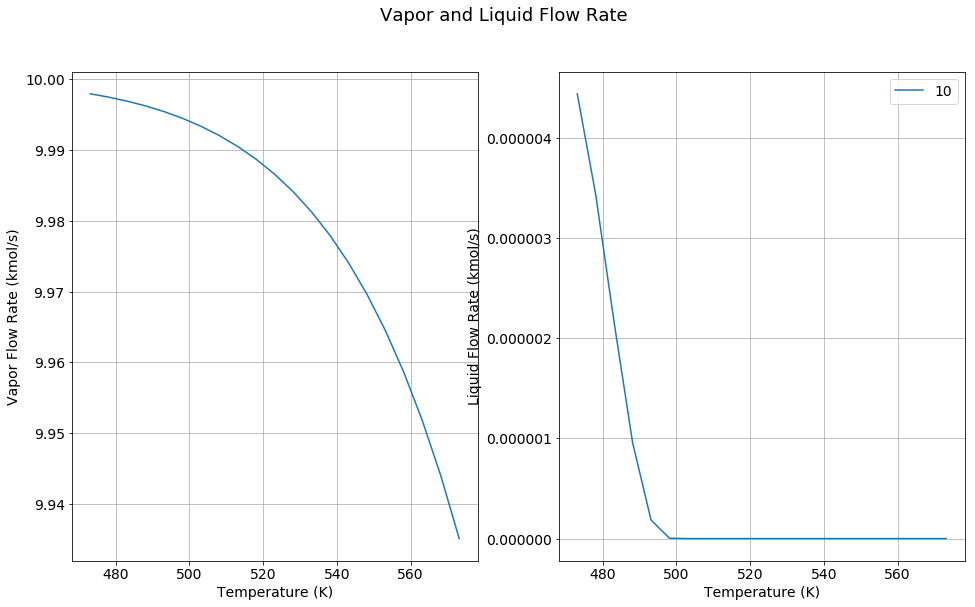

In [30]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,9))
for c in catrange:
    ax1.plot(Trange,rf_data_master[c]['V'])
ax1.set_ylabel('Vapor Flow Rate (kmol/s)',fontsize=14)
ax1.set_xlabel('Temperature (K)',fontsize=14)
ax1.tick_params(labelsize=14)
ax1.grid()

for c in catrange:
    ax2.plot(Trange,rf_data_master[c]['L'])
ax2.set_ylabel('Liquid Flow Rate (kmol/s)',fontsize=14)
ax2.set_xlabel('Temperature (K)',fontsize=14)
ax2.tick_params(labelsize=14)
ax2.grid()

ax2.legend(catrange,fontsize=14)
fig.suptitle('Vapor and Liquid Flow Rate',fontsize=18)

plt.show()

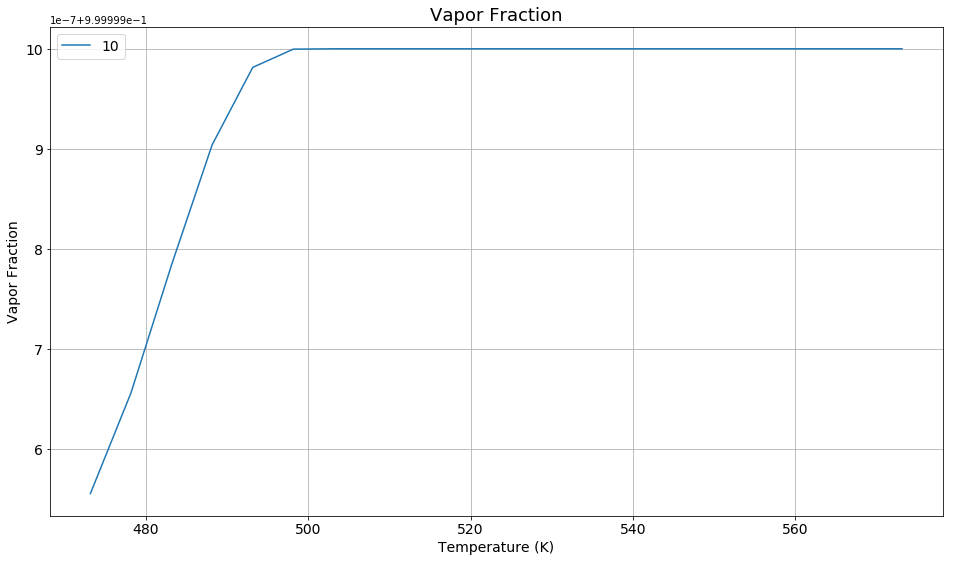

In [31]:
fig, ax1 = plt.subplots(figsize=(16,9))
for c in catrange:
    ax1.plot(Trange,np.divide(rf_data_master[c]['V'],np.add(rf_data_master[c]['V'],rf_data_master[c]['L'])))
ax1.set_ylabel('Vapor Fraction',fontsize=14)
ax1.set_xlabel('Temperature (K)',fontsize=14)
ax1.tick_params(labelsize=14)
ax1.legend(catrange,fontsize=14)
ax1.set_title('Vapor Fraction',fontsize=18)
ax1.grid()
plt.show()

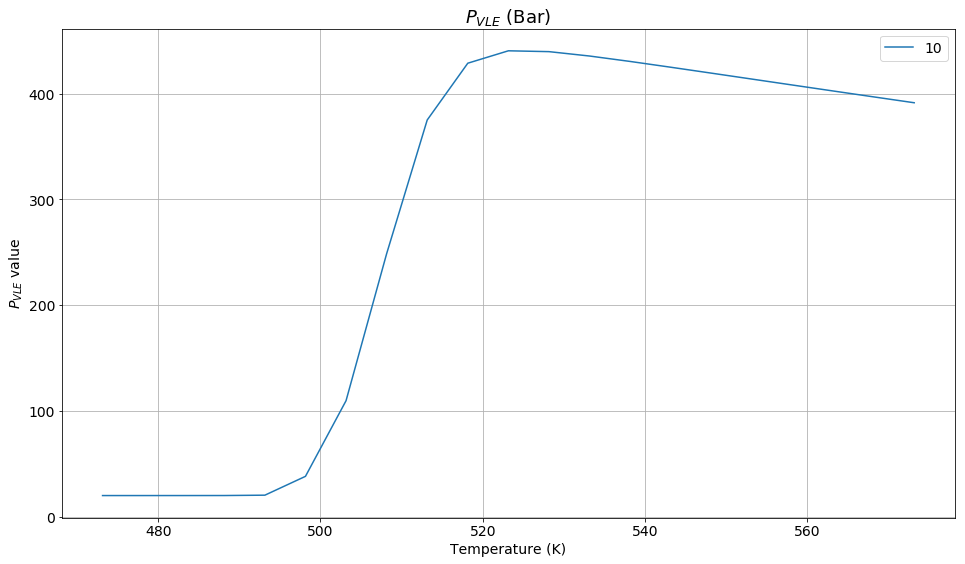

In [32]:
fig, ax1 = plt.subplots(figsize=(16,9))
for c in catrange:
    ax1.plot(Trange,rf_data_master[c]['P_VLE'])
ax1.set_ylabel(r'$P_{VLE}$ value',fontsize=14)
ax1.set_xlabel('Temperature (K)',fontsize=14)
ax1.tick_params(labelsize=14)
ax1.legend(catrange,fontsize=14)
ax1.set_title(r'$P_{VLE}$ (Bar)',fontsize=18)
ax1.grid()
plt.show()

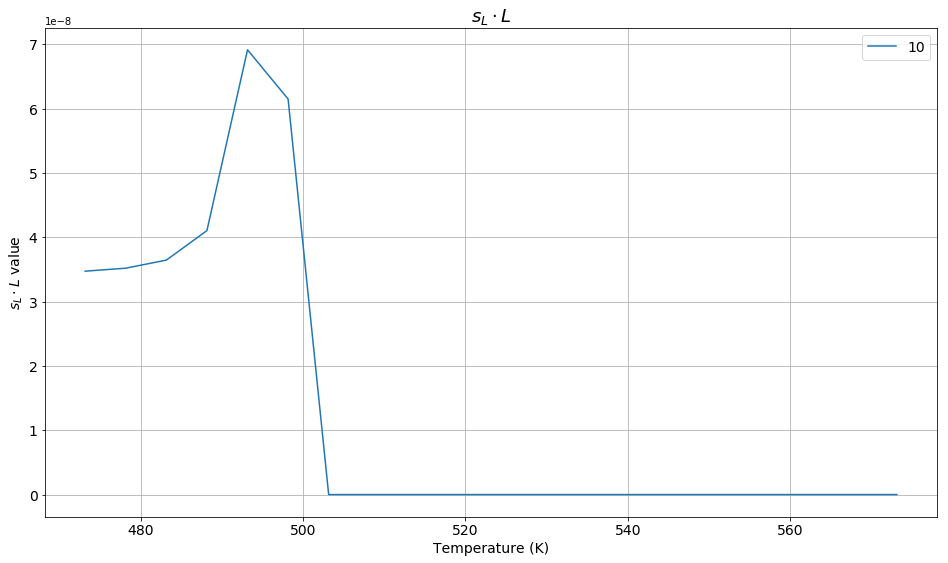

In [33]:
fig, ax1 = plt.subplots(figsize=(16,9))
for c in catrange:
    ax1.plot(Trange,np.multiply(rf_data_master[c]['s_L'],rf_data_master[c]['L']))
ax1.set_ylabel(r'$s_L \cdot L$ value',fontsize=14)
ax1.set_xlabel('Temperature (K)',fontsize=14)
ax1.tick_params(labelsize=14)
ax1.legend(catrange,fontsize=14)
# ax1.set_ylim(2.49e-5,2.51e-5)
ax1.set_title(r'$s_L \cdot L$',fontsize=18)
ax1.grid()
plt.show()